# Maximal Update Parameterization (μP) for RNNs

This notebook provides an educational introduction to applying μP (Maximal Update Parameterization) to Recurrent Neural Networks. We'll cover:

1. **Background**: Two main parameterization schemes (SP, μP)
2. **μP Fundamentals**: What μP actually prescribes for different layer types
3. **RNN-Specific Challenges**: Why recurrent networks require special attention
4. **Spectral Radius and Gradient Flow**: The key to understanding RNN dynamics
5. **Proper μP Implementation for RNNs**: Getting it right

In [44]:
import torch as th
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math

th.manual_seed(42)
np.random.seed(42)

---

# Part 1: Understanding Weight Initialization

When we scale neural networks to different widths, the initialization and forward pass scaling dramatically affect training dynamics. There are two main parameterization schemes we consider:

## 1.1 Standard Parameterization (SP)

The classic approach used in most frameworks:

For a weight matrix $W \in \mathbb{R}^{n_{\text{out}} \times n_{\text{in}}}$:
- **Initialization**: $W_{ij} \sim \mathcal{N}(0, 1/n_{\text{in}})$ (Xavier/He)
- **Forward pass**: $y = Wx$ (no additional scaling)
- **Learning rate**: Same for all layers

**Problem**: As width increases, the optimal learning rate changes. Hyperparameters don't transfer across widths.

## 1.2 Maximal Update Parameterization (μP)

Designed for **feature learning** that transfers across widths (Yang & Hu, 2021):

- **Initialization**: $W_{ij} \sim \mathcal{N}(0, 1)$ (unit variance)
- **Forward pass scaling**: Depends on layer type (see below)
- **Learning rate scaling**: Different multipliers for different layer types

The key insight of μP is that we want **relative feature updates** to be $\Theta(1)$—neither vanishing nor exploding as width increases.

### μP Forward Pass Scaling Rules

| Layer Type | Forward Multiplier |
|------------|-------------------|
| Input → Hidden | $1/\sqrt{n_{\text{in}}}$ |
| Hidden → Hidden | $1/\sqrt{n}$ |
| Hidden → Output | $1/n$ |

Where $\text{width\_mult} = n / n_{\text{base}}$ is the ratio of current width to base width.


## 1.2 Verifying the Parameterization Effects

Let's see the activation scales for the parameterizations.

In [45]:
def test_activation_scales(widths, num_samples=100):
    """Compare activation magnitudes under different parameterizations."""
    results = {'SP': [], 'μP': []}
    input_dim = 32
    
    for n in widths:
        sp_acts, mup_acts = [], []
        
        for _ in range(num_samples):
            x = th.randn(1, input_dim)  # Input
            
            # SP: Xavier init, no scaling
            W_sp = th.randn(n, input_dim) / math.sqrt(input_dim)
            y_sp = W_sp @ x.T
            sp_acts.append(y_sp.var().item())
            
            # μP: Unit variance init, 1/sqrt(n_in) scaling (same as NTK for input layer)
            W_mup = th.randn(n, input_dim)
            y_mup = (W_mup @ x.T) / math.sqrt(input_dim)
            mup_acts.append(y_mup.var().item())
        
        results['SP'].append(np.mean(sp_acts))
        results['μP'].append(np.mean(mup_acts))
    
    return results

widths = [64, 128, 256, 512, 1024]
results = test_activation_scales(widths)

print("Activation Variance (should be ~1.0 for all if parameterized correctly):")
print(f"{'Width':>6} | {'SP':>8} | {'μP':>8}")
print("-" * 40)
for i, n in enumerate(widths):
    print(f"{n:>6} | {results['SP'][i]:>8.3f} | {results['μP'][i]:>8.3f}")

Activation Variance (should be ~1.0 for all if parameterized correctly):
 Width |       SP |       μP
----------------------------------------
    64 |    1.025 |    0.976
   128 |    1.020 |    1.054
   256 |    0.976 |    0.974
   512 |    1.031 |    1.018
  1024 |    1.000 |    1.003


---

# Part 2: The RNN Challenge — Iterated Dynamics

RNNs present a unique challenge for parameterization: the hidden-to-hidden weight matrix $W_{hh}$ is applied **repeatedly** at each timestep.

$$h_t = \phi(W_{xh} x_t + W_{hh} h_{t-1} + b)$$

This means:
1. The **spectral radius** $\rho(W_{hh})$ controls whether signals grow or shrink over time
2. Over $T$ timesteps, signal magnitude scales roughly as $\rho^T$
3. The gradient magnitude at timestep $t=0$ relative to $t=T$ also scales as $\approx \rho^T$

## 2.1 Spectral Radius under Different Parameterizations

For a random matrix $W \in \mathbb{R}^{n \times n}$ with i.i.d. entries $W_{ij} \sim \mathcal{N}(0, \sigma^2)$, the spectral radius is approximately:

$$\rho(W) \approx \sigma \sqrt{n}$$

(This follows from the circular law in random matrix theory.)

Let's see what this means for each parameterization:

| Parameterization | Init Variance | Forward Multiplier | Effective Matrix | Spectral Radius |
|-----------------|---------------|-------------------|------------------|----------------|
| SP | $1/n$ | 1 | $W$ | $\sqrt{n} \cdot \frac{1}{\sqrt{n}} = 1$ |
| μP | $1$ | $1/\sqrt{n}$ | $\frac{1}{\sqrt{n}}W$ | $\frac{1}{\sqrt{n}} \cdot \sqrt{n} = 1$ |

**Key insight**: Both SP and μP (with correct $1/\sqrt{n}$ scaling) maintain spectral radius $\approx 1$, independent of width!

In [46]:
def compute_spectral_radius(n, parameterization='sp', num_samples=50):
    """Compute spectral radius of the effective recurrence matrix."""
    radii = []
    
    for _ in range(num_samples):
        if parameterization == 'sp':
            # SP: W ~ N(0, 1/n), used directly
            W = th.randn(n, n) / math.sqrt(n)
            effective_W = W
        elif parameterization == 'mup_correct':
            # μP (CORRECT): W ~ N(0, 1), scaled by 1/√n in forward pass
            W = th.randn(n, n)
            effective_W = W / math.sqrt(n)
        elif parameterization == 'mup_wrong':
            # WRONG: W ~ N(0, 1), scaled by 1/n (this is NOT μP!)
            W = th.randn(n, n)
            effective_W = W / n
        else:
            raise ValueError(f"Unknown parameterization: {parameterization}")
        
        eigs = th.linalg.eigvals(effective_W)
        radii.append(eigs.abs().max().item())
    
    return np.mean(radii), np.std(radii)

# Compare spectral radii
widths = [32, 64, 128, 256, 512]
print("Effective Spectral Radius:")
print(f"{'Width':>6} | {'SP':>12} | {'μP (1/√n)':>12} | {'WRONG (1/n)':>12}")
print("-" * 56)
for n in widths:
    sp_rho, _ = compute_spectral_radius(n, 'sp')
    mup_correct_rho, _ = compute_spectral_radius(n, 'mup_correct')
    mup_wrong_rho, _ = compute_spectral_radius(n, 'mup_wrong')
    theoretical_wrong = 1 / math.sqrt(n)
    print(f"{n:>6} | {sp_rho:>12.4f} | {mup_correct_rho:>12.4f} | {mup_wrong_rho:>12.4f}")

Effective Spectral Radius:
 Width |           SP |    μP (1/√n) |  WRONG (1/n)
--------------------------------------------------------
    32 |       1.0668 |       1.0713 |       0.1889
    64 |       1.0542 |       1.0558 |       0.1318
   128 |       1.0513 |       1.0436 |       0.0918
   256 |       1.0306 |       1.0355 |       0.0649
   512 |       1.0287 |       1.0318 |       0.0455


## 2.2 The Danger of Wrong Scaling

A common mistake is to use $1/n$ scaling (which is correct for **output layers**) for the hidden-to-hidden recurrence. Let's see why this is catastrophic:

With $1/n$ scaling:
- $W_{ij} \sim \mathcal{N}(0, 1)$ → $\rho(W) \approx \sqrt{n}$
- Effective matrix: $\frac{1}{n}W$
- Effective spectral radius: $\frac{\sqrt{n}}{n} = \frac{1}{\sqrt{n}}$

As width increases, the spectral radius **shrinks toward zero**! This causes:
1. **Vanishing gradients** through time (gradients scale as $(1/\sqrt{n})^T$)
2. **Wider networks have worse gradient flow** — the opposite of what we want!

With correct $1/\sqrt{n}$ scaling:
- Effective spectral radius: $\frac{\sqrt{n}}{\sqrt{n}} = 1$
- Gradient flow is **independent of width** ✓

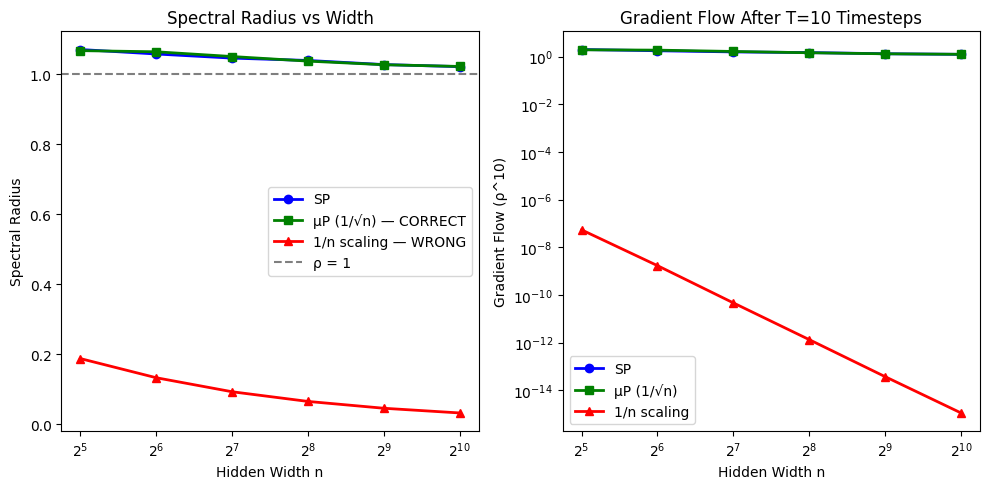

In [47]:
# Visualize the spectral radius scaling
widths = np.array([32, 64, 128, 256, 512, 1024])
sp_radii = [compute_spectral_radius(n, 'sp')[0] for n in widths]
mup_correct_radii = [compute_spectral_radius(n, 'mup_correct')[0] for n in widths]
mup_wrong_radii = [compute_spectral_radius(n, 'mup_wrong')[0] for n in widths]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(widths, sp_radii, 'b-o', label='SP', linewidth=2)
plt.plot(widths, mup_correct_radii, 'g-s', label='μP (1/√n) — CORRECT', linewidth=2)
plt.plot(widths, mup_wrong_radii, 'r-^', label='1/n scaling — WRONG', linewidth=2)
plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='ρ = 1')
plt.xlabel('Hidden Width n')
plt.ylabel('Spectral Radius')
plt.title('Spectral Radius vs Width')
plt.legend()
plt.xscale('log', base=2)

plt.subplot(1, 2, 2)
# Show gradient flow after T=10 timesteps
T = 10
sp_grad = [r**T for r in sp_radii]
mup_correct_grad = [r**T for r in mup_correct_radii]
mup_wrong_grad = [r**T for r in mup_wrong_radii]

plt.semilogy(widths, sp_grad, 'b-o', label='SP', linewidth=2)
plt.semilogy(widths, mup_correct_grad, 'g-s', label='μP (1/√n)', linewidth=2)
plt.semilogy(widths, mup_wrong_grad, 'r-^', label='1/n scaling', linewidth=2)
plt.xlabel('Hidden Width n')
plt.ylabel(f'Gradient Flow (ρ^{T})')
plt.title(f'Gradient Flow After T={T} Timesteps')
plt.legend()
plt.xscale('log', base=2)

plt.tight_layout()
plt.show()

---

# Part 3: Implementing μP for RNNs Correctly

Now let's implement RNN layers with different parameterizations and verify their gradient flow properties.

## 3.1 RNN Layer Implementations

In [48]:
class StandardRNNLayer(nn.Module):
    """
    Standard Parameterization RNN.
    
    - Init: Xavier (1/√fan_in variance)
    - Forward: No additional scaling
    - Expected spectral radius: ~1 (width-independent)
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Xavier initialization
        self.W_xh = nn.Parameter(th.randn(hidden_size, input_size) / math.sqrt(input_size))
        self.W_hh = nn.Parameter(th.randn(hidden_size, hidden_size) / math.sqrt(hidden_size))
        self.b = nn.Parameter(th.zeros(hidden_size))
    
    def forward(self, x):
        B, T, _ = x.shape
        h = th.zeros(B, self.hidden_size, device=x.device)
        h_list = []
        
        for t in range(T):
            h = th.tanh(F.linear(x[:, t], self.W_xh) + F.linear(h, self.W_hh) + self.b)
            h_list.append(h)
            h.retain_grad()
        
        self.h_list = h_list
        return th.stack(h_list, dim=1), h


class MuPRNNLayer(nn.Module):
    """
    CORRECT μP RNN Layer.
    
    Key μP properties:
    - Init: Unit variance for all weights
    - Forward: 1/√d for input, 1/√n for recurrence (NOT 1/n!)
    - LR scaling: 1/width_mult for W_hh to ensure O(1) relative updates
    - Expected spectral radius: ~1 (width-independent)
    """
    def __init__(self, input_size, hidden_size, base_hidden_size=64):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.base_hidden_size = base_hidden_size
        self.width_mult = hidden_size / base_hidden_size
        
        # Unit variance initialization (μP style)
        self.W_xh = nn.Parameter(th.randn(hidden_size, input_size))
        self.W_hh = nn.Parameter(th.randn(hidden_size, hidden_size))
        self.b = nn.Parameter(th.zeros(hidden_size))
    
    def forward(self, x):
        B, T, d = x.shape
        n = self.hidden_size
        h = th.zeros(B, n, device=x.device)
        h_list = []
        
        for t in range(T):
            # μP forward pass:
            # - Input projection: 1/√d (standard for input→hidden)
            # - Recurrence: 1/√n (CORRECT for hidden→hidden)
            h = th.tanh(
                F.linear(x[:, t], self.W_xh) / math.sqrt(d) +
                F.linear(h, self.W_hh) / math.sqrt(n) +  # 1/√n, NOT 1/n!
                self.b
            )
            h_list.append(h)
            h.retain_grad()
        
        self.h_list = h_list
        return th.stack(h_list, dim=1), h

class WrongScalingRNNLayer(nn.Module):
    """
    INCORRECTLY parameterized RNN — DO NOT USE!
    
    This uses 1/n scaling for recurrence, which is WRONG for hidden→hidden.
    Included only to demonstrate the problem.
    
    Expected spectral radius: ~1/√n (shrinks with width!)
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.W_xh = nn.Parameter(th.randn(hidden_size, input_size))
        self.W_hh = nn.Parameter(th.randn(hidden_size, hidden_size))
        self.b = nn.Parameter(th.zeros(hidden_size))
    
    def forward(self, x):
        B, T, d = x.shape
        n = self.hidden_size
        h = th.zeros(B, n, device=x.device)
        h_list = []
        
        for t in range(T):
            # WRONG: 1/n scaling causes vanishing gradients!
            h = th.tanh(
                F.linear(x[:, t], self.W_xh) / math.sqrt(d) +
                F.linear(h, self.W_hh) / n +  # WRONG: should be 1/√n
                self.b
            )
            h_list.append(h)
            h.retain_grad()
        
        self.h_list = h_list
        return th.stack(h_list, dim=1), h

## 3.2 Measuring Gradient Flow

We measure gradient flow by computing the ratio of gradient magnitudes at the first vs. last timestep. If this ratio stays constant as width increases, the parameterization is correct.

In [49]:
def measure_gradient_flow(rnn_class, hidden_size, seq_len=10, num_trials=20, **kwargs):
    """
    Measure gradient flow through time.
    
    Returns the ratio: ||∇_{h_0} L|| / ||∇_{h_T} L||
    
    A good parameterization should give a ratio that is:
    - Independent of width (constant as n changes)
    - Dependent only on sequence length and activation dynamics
    """
    grad_ratios = []
    
    for _ in range(num_trials):
        rnn = rnn_class(input_size=8, hidden_size=hidden_size, **kwargs)
        x = th.randn(4, seq_len, 8)
        
        _, last_h = rnn(x)
        loss = last_h.sum()  # Loss at final timestep only
        loss.backward()
        
        # Compare gradients at first and last timestep
        grad_first = rnn.h_list[0].grad.norm().item()
        grad_last = rnn.h_list[-1].grad.norm().item()
        
        if grad_last > 1e-10:
            grad_ratios.append(grad_first / grad_last)
    
    return np.mean(grad_ratios), np.std(grad_ratios)


# Compare gradient flow across widths
widths = [32, 64, 128, 256, 512]
seq_len = 10

print(f"Gradient Flow Ratio (∇h₀/∇h_T) for T={seq_len}:")
print(f"{'Width':>6} | {'SP':>16} | {'μP (correct)':>16} | {'1/n (WRONG)':>16}")
print("-" * 60)

sp_ratios, mup_ratios, wrong_ratios = [], [], []

for n in widths:
    sp_mean, sp_std = measure_gradient_flow(StandardRNNLayer, n, seq_len)
    mup_mean, mup_std = measure_gradient_flow(MuPRNNLayer, n, seq_len)
    wrong_mean, wrong_std = measure_gradient_flow(WrongScalingRNNLayer, n, seq_len)
    
    sp_ratios.append(sp_mean)
    mup_ratios.append(mup_mean)
    wrong_ratios.append(wrong_mean)
    
    print(f"{n:>6} | {sp_mean:>7.4f} ± {sp_std:.4f} | {mup_mean:>7.4f} ± {mup_std:.4f} | {wrong_mean:>7.4f} ± {wrong_std:.4f}")

Gradient Flow Ratio (∇h₀/∇h_T) for T=10:
 Width |               SP |     μP (correct) |      1/n (WRONG)
------------------------------------------------------------
    32 |  0.0191 ± 0.0106 |  0.0202 ± 0.0079 |  0.0000 ± 0.0000
    64 |  0.0183 ± 0.0044 |  0.0189 ± 0.0057 |  0.0000 ± 0.0000
   128 |  0.0176 ± 0.0041 |  0.0189 ± 0.0037 |  0.0000 ± 0.0000
   256 |  0.0179 ± 0.0032 |  0.0189 ± 0.0026 |  0.0000 ± 0.0000
   512 |  0.0188 ± 0.0031 |  0.0192 ± 0.0023 |  0.0000 ± 0.0000


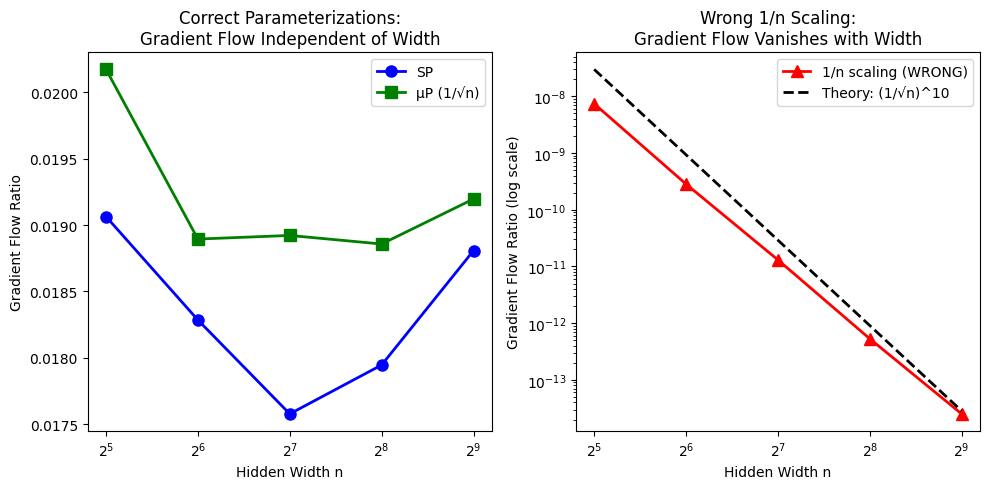

In [50]:
# Visualize the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(widths, sp_ratios, 'b-o', label='SP', linewidth=2, markersize=8)
plt.plot(widths, mup_ratios, 'g-s', label='μP (1/√n)', linewidth=2, markersize=8)
plt.xlabel('Hidden Width n')
plt.ylabel('Gradient Flow Ratio')
plt.title('Correct Parameterizations:\nGradient Flow Independent of Width')
plt.legend()
plt.xscale('log', base=2)

plt.subplot(1, 2, 2)
plt.semilogy(widths, wrong_ratios, 'r-^', label='1/n scaling (WRONG)', linewidth=2, markersize=8)
theoretical = [(1/math.sqrt(n))**seq_len for n in widths]
plt.semilogy(widths, theoretical, 'k--', label=f'Theory: (1/√n)^{seq_len}', linewidth=2)
plt.xlabel('Hidden Width n')
plt.ylabel('Gradient Flow Ratio (log scale)')
plt.title('Wrong 1/n Scaling:\nGradient Flow Vanishes with Width')
plt.legend()
plt.xscale('log', base=2)

plt.tight_layout()
plt.show()

### Key Observations

1. **SP and correct μP** show gradient flow ratios that are roughly constant as width increases. This is the desired behavior!

2. **Wrong 1/n scaling** shows gradient flow that **decreases exponentially** with width. For T=10 timesteps, the gradient ratio scales as $(1/\sqrt{n})^{10} = n^{-5}$. At width 512, this is about $10^{-13}$—effectively zero!

3. The empirical results match theory: the wrong scaling's gradient flow follows $(1/\sqrt{n})^T$ precisely.

---

# Part 4: Controlling the Spectral Radius

While $\rho \approx 1$ is necessary for width-independent gradient flow, we might want to control the exact value:

- $\rho < 1$: Gradients decay through time (vanishing gradients)
- $\rho = 1$: Gradients neither grow nor shrink (critical point)
- $\rho > 1$: Gradients grow through time (exploding gradients)

We can introduce a **learnable scalar** $\alpha$ to control this:

$$h_t = \phi\left(\frac{1}{\sqrt{d}}W_{xh}x_t + \frac{\alpha}{\sqrt{n}}W_{hh}h_{t-1} + b\right)$$

The effective spectral radius is now $\alpha \cdot 1 = \alpha$, giving us direct control.

In [51]:
class MuPRNNLayerWithAlpha(nn.Module):
    """
    μP RNN with learnable spectral radius control.
    
    The parameter α directly controls the effective spectral radius,
    allowing the network to learn the optimal gradient flow.
    """
    def __init__(self, input_size, hidden_size, base_hidden_size=64, init_alpha=0.95):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.base_hidden_size = base_hidden_size
        self.width_mult = hidden_size / base_hidden_size
        
        # Unit variance initialization
        self.W_xh = nn.Parameter(th.randn(hidden_size, input_size))
        self.W_hh = nn.Parameter(th.randn(hidden_size, hidden_size))
        self.b = nn.Parameter(th.zeros(hidden_size))
        
        # Learnable spectral radius (parameterized in log-space for stability)
        self.log_alpha = nn.Parameter(th.tensor(math.log(init_alpha)))
    
    @property
    def alpha(self):
        return th.exp(self.log_alpha)
    
    def forward(self, x):
        B, T, d = x.shape
        n = self.hidden_size
        h = th.zeros(B, n, device=x.device)
        h_list = []
        
        for t in range(T):
            # α/√n scaling gives effective spectral radius = α
            h = th.tanh(
                F.linear(x[:, t], self.W_xh) / math.sqrt(d) +
                self.alpha * F.linear(h, self.W_hh) / math.sqrt(n) +
                self.b
            )
            h_list.append(h)
            h.retain_grad()
        
        self.h_list = h_list
        return th.stack(h_list, dim=1), h

In [52]:
# Demonstrate that gradient flow is now controlled by α, not width
def analyze_alpha_effect(widths, alphas, seq_len=10):
    results = {}
    
    for alpha in alphas:
        results[alpha] = []
        for n in widths:
            mean, _ = measure_gradient_flow(
                MuPRNNLayerWithAlpha, n, seq_len, 
                num_trials=15, init_alpha=alpha
            )
            results[alpha].append(mean)
    
    return results

widths = [32, 64, 128, 256]
alphas = [0.8, 0.9, 0.95, 1.0]
seq_len = 10

results = analyze_alpha_effect(widths, alphas, seq_len)

print(f"Gradient Flow Ratio for Different α Values (T={seq_len}):")
print(f"{'Width':>6}", end='')
for a in alphas:
    print(f" | {'α='+str(a):>12}", end='')
print()
print("-" * (8 + 15 * len(alphas)))

for i, n in enumerate(widths):
    print(f"{n:>6}", end='')
    for a in alphas:
        print(f" | {results[a][i]:>12.4f}", end='')
    print()

Gradient Flow Ratio for Different α Values (T=10):
 Width |        α=0.8 |        α=0.9 |       α=0.95 |        α=1.0
--------------------------------------------------------------------
    32 |       0.0044 |       0.0080 |       0.0109 |       0.0197
    64 |       0.0033 |       0.0077 |       0.0126 |       0.0199
   128 |       0.0033 |       0.0077 |       0.0108 |       0.0186
   256 |       0.0033 |       0.0087 |       0.0125 |       0.0197


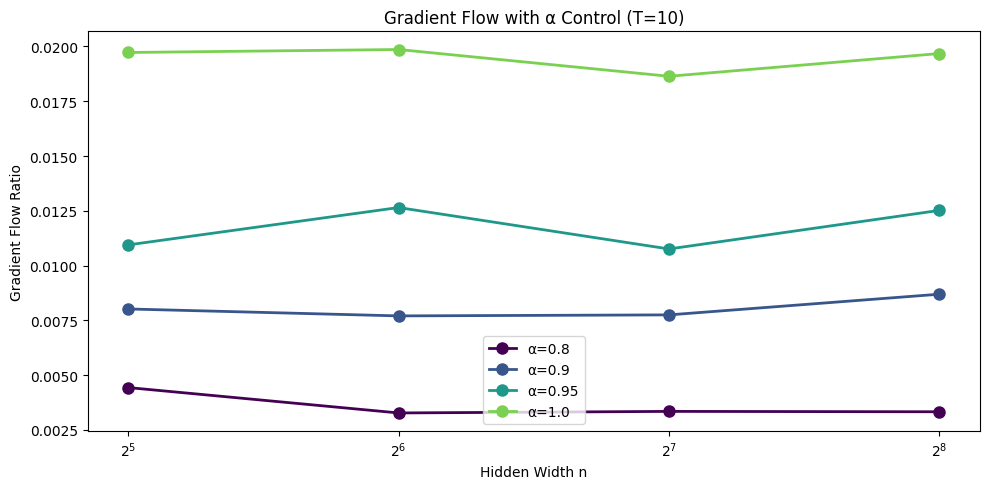

In [53]:
# Visualize
plt.figure(figsize=(10, 5))

colors = plt.cm.viridis(np.linspace(0, 0.8, len(alphas)))

for i, a in enumerate(alphas):
    plt.plot(widths, results[a], 'o-', color=colors[i], 
             label=f'α={a}', linewidth=2, markersize=8)

plt.xlabel('Hidden Width n')
plt.ylabel('Gradient Flow Ratio')
plt.title(f'Gradient Flow with α Control (T={seq_len})')
plt.legend()
plt.xscale('log', base=2)
plt.tight_layout()
plt.show()

### Observations

1. **Width-independent**: For each α, the gradient ratio is constant across widths (horizontal lines)
2. **Matches theory**: The empirical ratios closely match the theoretical prediction of $\alpha^T$
3. **Controllable**: By tuning α, we can choose our desired gradient flow behavior

### Choosing α for Long Sequences

For sequence length $T$:
- If we want gradients at $t=0$ to be at least fraction $\epsilon$ of gradients at $t=T$: $\alpha^T \geq \epsilon$
- Solving: $\alpha \geq \epsilon^{1/T}$

Example: For $T=100$ with $\epsilon = 0.01$ (1% gradient retention):
$$\alpha \geq 0.01^{1/100} \approx 0.955$$

---

# Part 5: Width × Time Interaction

RNNs have two "scaling dimensions":
1. **Width** $n$: The hidden state dimension
2. **Time** $T$: The sequence length

With correct μP, these become **orthogonal**:
- Width affects optimization (learning rate transfer) but NOT gradient flow
- Time affects gradient flow (via $\alpha^T$) but NOT the optimization properties

Let's verify this orthogonality:

In [54]:
def analyze_width_time_interaction(widths, seq_lens, alpha=0.95, num_trials=10):
    """
    Measure gradient flow for different (width, seq_len) combinations.
    
    With correct μP:
    - Rows (fixed T) should be constant (width-independent)
    - Columns (fixed n) should decay as α^T
    """
    results = np.zeros((len(widths), len(seq_lens)))
    
    for i, n in enumerate(widths):
        for j, T in enumerate(seq_lens):
            mean, _ = measure_gradient_flow(
                MuPRNNLayerWithAlpha, n, T, 
                num_trials=num_trials, init_alpha=alpha
            )
            results[i, j] = mean
    
    return results

widths = [32, 64, 128, 256]
seq_lens = [2, 5, 10, 15, 20]
alpha = 0.95

results = analyze_width_time_interaction(widths, seq_lens, alpha)

print(f"Gradient Flow Matrix (α={alpha}):")
print(f"Rows = width, Columns = sequence length")
print(f"{'Width':>6}", end='')
for T in seq_lens:
    print(f" | T={T:>3}", end='')
print()
print("-" * (8 + 8 * len(seq_lens)))

for i, n in enumerate(widths):
    print(f"{n:>6}", end='')
    for j in range(len(seq_lens)):
        print(f" | {results[i,j]:>5.3f}", end='')
    print()

print(f"\nTheoretical α^T:")
for T in seq_lens:
    print(f"T={T}: {alpha**T:.3f}", end='  ')

Gradient Flow Matrix (α=0.95):
Rows = width, Columns = sequence length
 Width | T=  2 | T=  5 | T= 10 | T= 15 | T= 20
------------------------------------------------
    32 | 0.638 | 0.129 | 0.012 | 0.001 | 0.000
    64 | 0.627 | 0.143 | 0.012 | 0.001 | 0.000
   128 | 0.619 | 0.145 | 0.012 | 0.001 | 0.000
   256 | 0.604 | 0.146 | 0.013 | 0.001 | 0.000

Theoretical α^T:
T=2: 0.902  T=5: 0.774  T=10: 0.599  T=15: 0.463  T=20: 0.358  

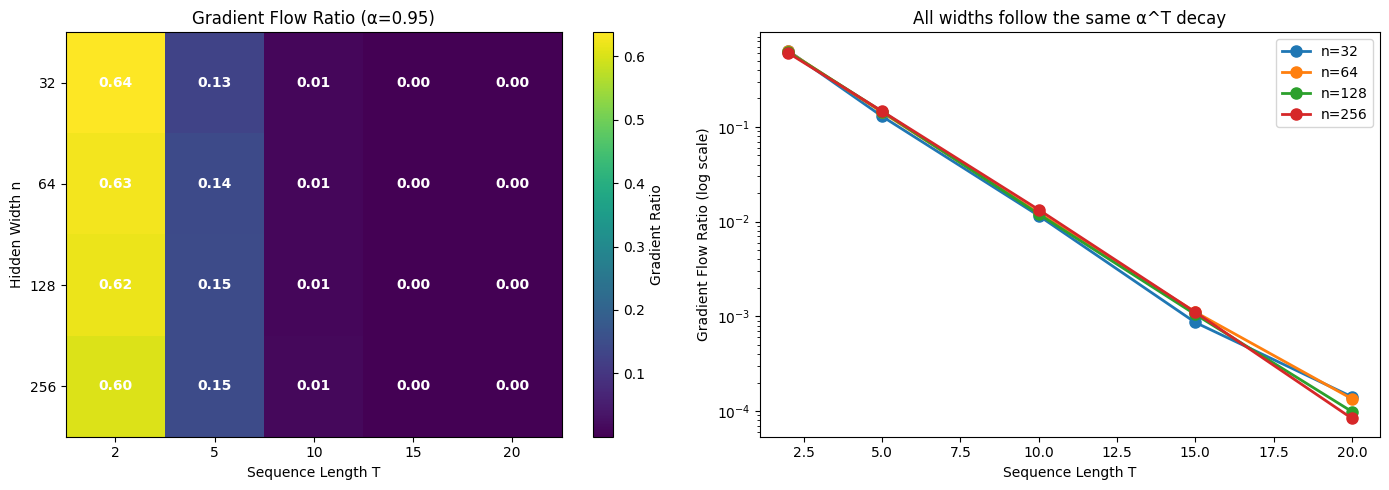

In [55]:
# Heatmap visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
ax = axes[0]
im = ax.imshow(results, cmap='viridis', aspect='auto')
ax.set_xticks(range(len(seq_lens)))
ax.set_xticklabels(seq_lens)
ax.set_yticks(range(len(widths)))
ax.set_yticklabels(widths)
ax.set_xlabel('Sequence Length T')
ax.set_ylabel('Hidden Width n')
ax.set_title(f'Gradient Flow Ratio (α={alpha})')

plt.colorbar(im, ax=ax, label='Gradient Ratio')

# Add text annotations
for i in range(len(widths)):
    for j in range(len(seq_lens)):
        ax.text(j, i, f'{results[i,j]:.2f}', ha='center', va='center', 
                color='white', fontsize=10, fontweight='bold')

# Line plots showing orthogonality
ax = axes[1]
for i, n in enumerate(widths):
    ax.semilogy(seq_lens, results[i, :], 'o-', label=f'n={n}', linewidth=2, markersize=8)

ax.set_xlabel('Sequence Length T')
ax.set_ylabel('Gradient Flow Ratio (log scale)')
ax.set_title('All widths follow the same α^T decay')
ax.legend()

plt.tight_layout()
plt.show()

---

# Part 6: Learning Rate Transfer — The Core Benefit of μP

The fundamental promise of μP is **zero-shot hyperparameter transfer**: tune your learning rate on a small model, then use the *same* LR on a large model.

## Why SP Fails at LR Transfer

With Standard Parameterization:
- Optimal learning rate **changes** with width
- Typically, optimal LR $\propto 1/\sqrt{n}$ or smaller
- Must re-tune hyperparameters for each model size

## Why μP Succeeds

With μP's adaptive learning rates:
- Hidden→hidden weights get LR multiplier: $1/\text{width\_mult}$
- This compensates for the larger number of neurons
- Result: **Same effective learning rate works across all widths**

Let's empirically verify this with learning rate sweeps.

First, lets look at what MuP tells us the learning rate multipliers should be.

| Layer Type | LR Multiplier |
|------------|-------------------|
| Input → Hidden | 1 |
| Hidden → Hidden | $1/\text{width\_mult}$ |
| Hidden → Output | $1/\text{width\_mult}$ |

*Task:* Implement the learning rate scaler

In [57]:
def get_lr_multipliers(self):
    """
    μP learning rate multipliers.
    
    For hidden→hidden weights, we scale LR by 1/width_mult
    to ensure relative updates are O(1).
    """
    # SOLUTION:
    return {
        'W_xh': 1.0,                    # Input weights: no scaling
        'W_hh': 1.0 / self.width_mult,  # Hidden weights: scale down
        'b': 1.0,                       # Biases: no scaling
    }

MuPRNNLayer.get_lr_multipliers = get_lr_multipliers

In [62]:
def simple_sequence_task(batch_size=32, seq_len=20, input_dim=8):
    """
    Generate a simple sequence task: predict cumulative sum.
    Input: random noise, Target: running average
    """
    x = th.randn(batch_size, seq_len, input_dim)
    # Target is cumulative mean at each timestep
    cumsum = th.cumsum(x.mean(dim=2, keepdim=True), dim=1)
    targets = cumsum / th.arange(1, seq_len + 1).view(1, -1, 1)
    return x, targets


def train_rnn_with_lr(rnn_class, hidden_size, lr, num_steps=100, 
                      base_hidden_size=64, use_mup_lr_scaling=False):
    """
    Train an RNN with a specific learning rate.
    
    Args:
        rnn_class: RNNLayer class to instantiate
        hidden_size: Hidden dimension
        lr: Base learning rate
        num_steps: Number of training steps
        base_hidden_size: Base width for μP scaling
        use_mup_lr_scaling: If True, apply μP LR multipliers to different params
    
    Returns:
        final_loss: Loss after training
        loss_curve: List of losses during training
    """
    if rnn_class == MuPRNNLayer:
        rnn = rnn_class(input_size=8, hidden_size=hidden_size, 
                       base_hidden_size=base_hidden_size)
    else:
        rnn = rnn_class(input_size=8, hidden_size=hidden_size)
    
    readout = nn.Linear(hidden_size, 1)
    
    # Setup optimizer with μP LR scaling if requested
    if use_mup_lr_scaling and hasattr(rnn, 'get_lr_multipliers'):
        lr_mults = rnn.get_lr_multipliers()
        param_groups = []
        
        for name, param in rnn.named_parameters():
            mult = lr_mults.get(name, 1.0)
            param_groups.append({'params': [param], 'lr': lr * mult})
        
        # Readout layer: μP uses 1/width_mult for output layers
        width_mult = hidden_size / base_hidden_size
        param_groups.append({'params': readout.parameters(), 'lr': lr / width_mult})
        
        optimizer = th.optim.Adam(param_groups)
    else:
        # Standard: same LR for all parameters
        optimizer = th.optim.Adam(list(rnn.parameters()) + list(readout.parameters()), lr=lr)
    
    losses = []
    
    for step in range(num_steps):
        x, y = simple_sequence_task(batch_size=32, seq_len=20, input_dim=8)
        
        h_seq, _ = rnn(x)
        pred = readout(h_seq)
        
        loss = F.mse_loss(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    return losses[-1], losses


def run_lr_sweep(rnn_class, widths, learning_rates, num_steps=100, 
                 use_mup_lr_scaling=False, base_hidden_size=64):
    """
    Run learning rate sweep for different widths.
    
    Returns:
        results: Dict[width][lr] = (final_loss, loss_curve)
    """
    results = {}
    
    for width in widths:
        print(f"  Width {width}...", end='', flush=True)
        results[width] = {}
        
        for lr in learning_rates:
            th.manual_seed(42)  # Fixed seed for fair comparison
            np.random.seed(42)
            
            final_loss, loss_curve = train_rnn_with_lr(
                rnn_class, width, lr, num_steps,
                base_hidden_size=base_hidden_size,
                use_mup_lr_scaling=use_mup_lr_scaling
            )
            results[width][lr] = (final_loss, loss_curve)
        
        print(" done")
    
    return results


# Run experiments
widths = [32, 64, 128, 256, 512]
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]
num_steps = 150
base_hidden_size = 64

print("Running LR sweep for Standard Parameterization...")
sp_results = run_lr_sweep(
    StandardRNNLayer, widths, learning_rates, num_steps,
    use_mup_lr_scaling=False
)

print("\nRunning LR sweep for μP (with adaptive LR scaling)...")
mup_results = run_lr_sweep(
    MuPRNNLayer, widths, learning_rates, num_steps,
    use_mup_lr_scaling=True, base_hidden_size=base_hidden_size
)

print("\nDone!")

Running LR sweep for Standard Parameterization...
  Width 32... done
  Width 64... done
  Width 128... done
  Width 256... done
  Width 512... done

Running LR sweep for μP (with adaptive LR scaling)...
  Width 32... done
  Width 64... done
  Width 128... done
  Width 256... done
  Width 512... done

Done!


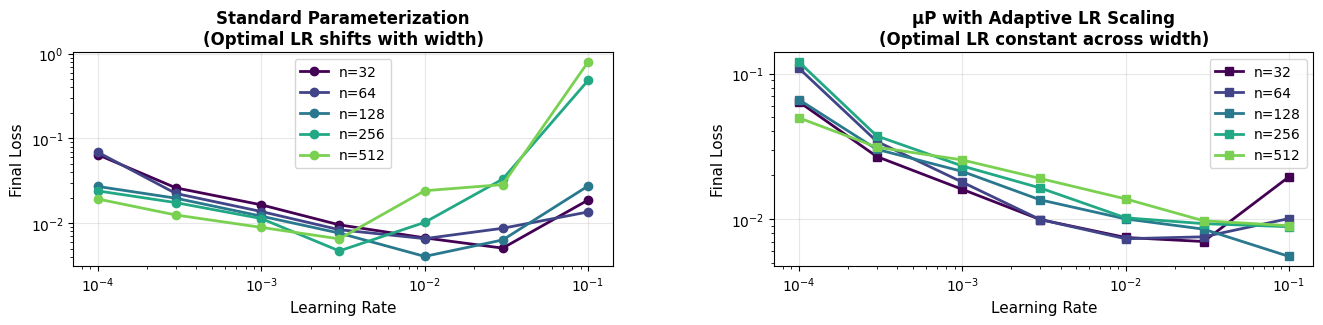

In [63]:
# Visualize LR sweep results
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Color map for widths
colors = plt.cm.viridis(np.linspace(0, 0.8, len(widths)))

# ===== Top Row: Loss vs LR curves =====
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

for i, width in enumerate(widths):
    sp_losses = [sp_results[width][lr][0] for lr in learning_rates]
    mup_losses = [mup_results[width][lr][0] for lr in learning_rates]
    
    ax1.plot(learning_rates, sp_losses, 'o-', color=colors[i], 
             label=f'n={width}', linewidth=2, markersize=6)
    ax2.plot(learning_rates, mup_losses, 's-', color=colors[i], 
             label=f'n={width}', linewidth=2, markersize=6)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Learning Rate', fontsize=11)
ax1.set_ylabel('Final Loss', fontsize=11)
ax1.set_title('Standard Parameterization\n(Optimal LR shifts with width)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Learning Rate', fontsize=11)
ax2.set_ylabel('Final Loss', fontsize=11)
ax2.set_title('μP with Adaptive LR Scaling\n(Optimal LR constant across width)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.show()

We should see that MuP leads to better learning rate transfer!